# Neural Network - 6 Hourly Demand Prediction

In this section we predict the 6-hourly demand of taxi trips in Chicago. 
The prediciton we perform by building a model are based on data from 2013, provided from Chicago (website: https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew).

We split the prediction into spatial units:
- Community Areas
- Hexagons with low resolution
- Hexagons with medium resolution
- Hexagons with high resolution

For each of the units we perform a seperate prediction based on data we have aggregeated in our preparation.

Our procedure in this part is structured in the following way:

- Explore different Neural Network architectures to find out which performs best. We do this based on Community areas.
- Hyperparameter tuning to find the best Neural Network Architecture
- Make predictions for all spatial units with the Architecture winner of the Hyperparametertuning
- Evaluation

<hr style="border: 1px solid #8888;">

In [1]:
#pip install keras_tuner

In [2]:
# Import all necessary packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy.stats import loguniform
import predictive as pred
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error
import os.path

# Import keras libraries
import tensorflow
from tensorflow import keras
from keras import layers
import keras_tuner
from keras_tuner.tuners import Hyperband
import IPython

<hr style="border: 1px solid #8888;">

## Preprocessing

In [3]:
# import datasets
df_6h_comar = pd.read_csv("../data/datasets/df_6h_comar.csv")
df_6h_hexlow = pd.read_csv("../data/datasets/df_6h_hexlow.csv")
df_6h_hexmed = pd.read_csv("../data/datasets/df_6h_hexmed.csv")
df_6h_hexhig = pd.read_csv("../data/datasets/df_6h_hexhig.csv")

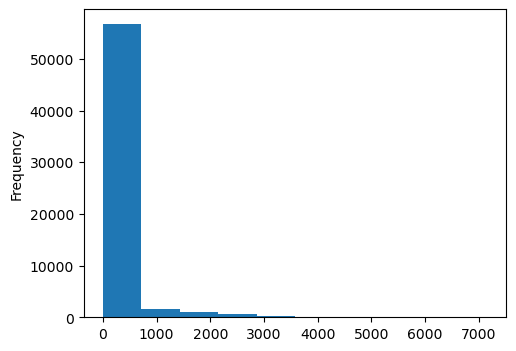

In [4]:
plt.figure(figsize=(12,4)) 

plt.subplot(121)  
df_6h_comar['numOfTaxis_area'].plot.hist()

#plt.subplot(122)
#df_6h_comar['numOfTaxis_area'] = np.log(df_6h_comar['numOfTaxis_area'])
#df_6h_comar['numOfTaxis_area'].plot.hist()
plt.show()

Even if the distribution does not look good, we do not use the log transformation at this point, because only simple neural networks benefit from it, but more complex ones even become worse (**we have tested this!**).

In [5]:
#df_6h_hexlow['numOfTaxis_area'] = np.log(df_6h_hexlow['numOfTaxis_area'])
#df_6h_hexmed['numOfTaxis_area'] = np.log(df_6h_hexmed['numOfTaxis_area'])
#df_6h_hexhig['numOfTaxis_area'] = np.log(df_6h_hexhig['numOfTaxis_area'])

In [6]:
df_6h_comar.drop(columns = ['date_start'],inplace = True)
df_6h_hexlow.drop(columns = ['date_start'],inplace = True)
df_6h_hexmed.drop(columns = ['date_start'],inplace = True)
df_6h_hexhig.drop(columns = ['date_start'],inplace = True)

In [7]:
df_6h_comar = pred.dayandseas_to_int(df_6h_comar)
df_6h_hexlow = pred.dayandseas_to_int(df_6h_hexlow)
df_6h_hexmed = pred.dayandseas_to_int(df_6h_hexmed)
df_6h_hexhig = pred.dayandseas_to_int(df_6h_hexhig)

C:\Users\Benny\AppData\Local\Temp\ipykernel_744\1214645829.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_6h_comar.drop(columns = ['numOfTaxis_area']).corr()


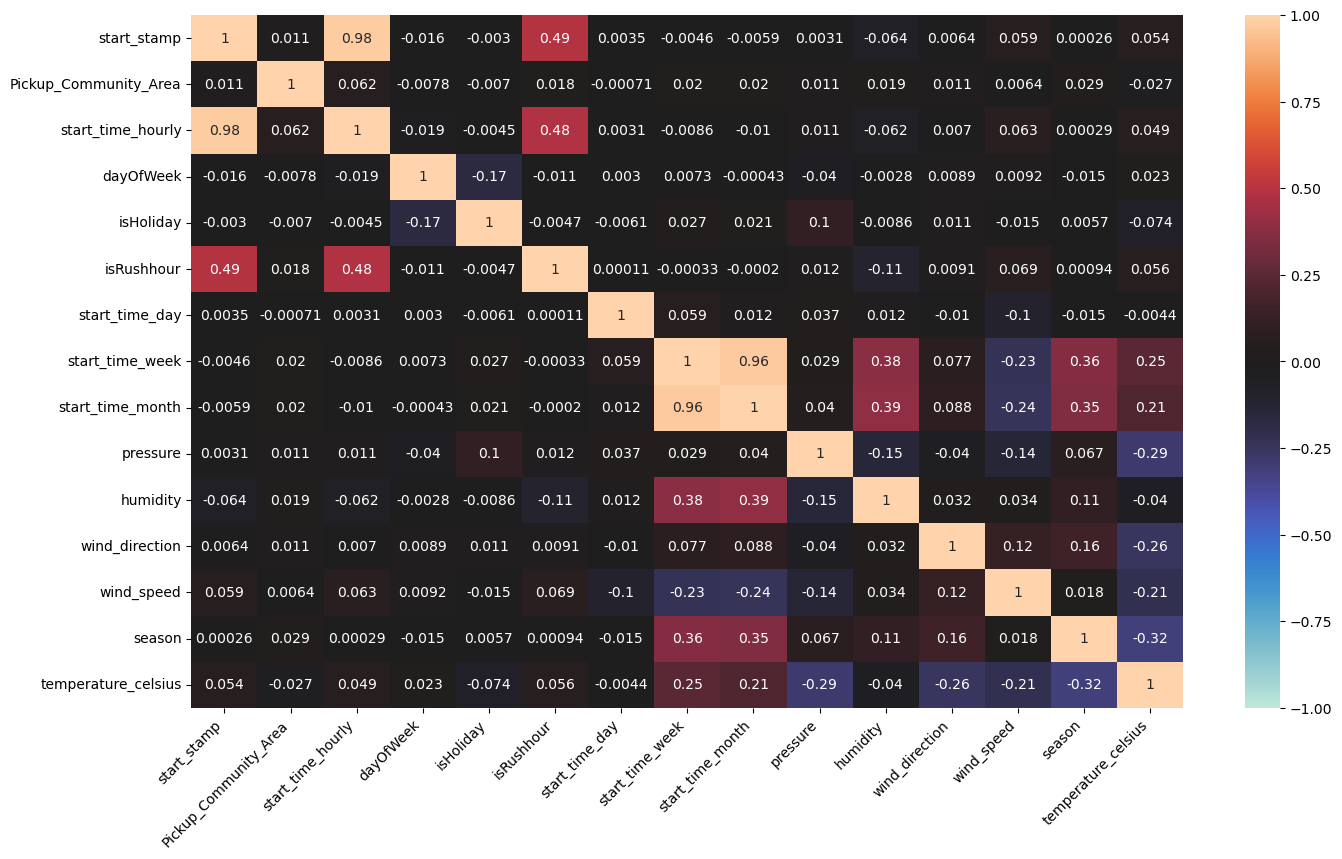

In [8]:
# correlation matrix of df_h_comar

import seaborn as sns
corr = df_6h_comar.drop(columns = ['numOfTaxis_area']).corr()
plt.figure(figsize = (16,9))
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, annot=True)

ax.set_xticklabels(ax.get_xticklabels(),
                  rotation = 45,
                  horizontalalignment = 'right')

ax.set_yticklabels(ax.get_yticklabels(),
                   rotation =0,
                   horizontalalignment = 'right')

plt.show()

We have a very high correlation between `start_time_month` and `start_time_week`, which leads to dropping `start_time_month`. Also we observe a high correlation between `start_time_hourly` and `start_stamp`. So we are dropping `start_time_hourly`, because we are interested in the 6-hourly interval (which start is represented by `start_stamp`):

In [9]:
df_6h_comar.drop(columns = ['start_time_month'],inplace = True)

In [10]:
df_6h_comar.drop(columns = ['start_time_hourly'],inplace = True)

Doing the same for the dataframes of:

- hexagons with low resolution
- hexagons with medium resolution
- hexagons with high resolution

In [11]:
df_6h_hexlow.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_6h_hexmed.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)
df_6h_hexhig.drop(columns = ['start_time_hourly','start_time_month'],inplace = True)

<hr style="border: 1px solid #8888;">

## General functions

In [12]:
# Calculate Metrics
def evaluate_performance(y_test,pred_ann,df):
    print("MODEL SCORES")
    print("MAE:", round(mean_absolute_error(y_test,pred_ann), 4))
    print("MSE:", round(mean_squared_error(y_test, pred_ann), 4))
    print("RMSE:", round(mean_squared_error(y_test,pred_ann)**0.5, 4))
    print("MAPE:", round(mean_absolute_percentage_error(y_test,pred_ann), 4))
    print("Rough Accuracy Approximation:", round((1-(mean_absolute_error(y_test,pred_ann)/df["numOfTaxis_area"].mean()))*100,2), "%")
    print("R2:", round(r2_score(y_test,pred_ann)*100, 2), "%")
    print("Max Residual Error:", round(max_error(y_test,pred_ann), 4))

<hr style="border: 1px solid #8888;">

## 1. 6-Hourly Demand - Community Area

- Before running you have to install tensorflow: `pip install tensorflow`

### **Feature engineering**

Here we will shortly create dummy variables and split the data and normalize it

In [13]:
df_6h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60148 entries, 0 to 60147
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   start_stamp            60148 non-null  int64  
 1   Pickup_Community_Area  60148 non-null  float64
 2   numOfTaxis_area        60148 non-null  int64  
 3   dayOfWeek              60148 non-null  int64  
 4   isHoliday              60148 non-null  bool   
 5   isRushhour             60148 non-null  bool   
 6   start_time_day         60148 non-null  int64  
 7   start_time_week        60148 non-null  int64  
 8   pressure               60148 non-null  float64
 9   humidity               60148 non-null  float64
 10  wind_direction         60148 non-null  float64
 11  wind_speed             60148 non-null  float64
 12  description            60148 non-null  object 
 13  season                 60148 non-null  int64  
 14  temperature_celsius    60148 non-null  float64
dtypes:

In [14]:
# Prepare variables for dummy creation
df_6h_comar['start_stamp'] = df_6h_comar['start_stamp'].astype(str)
df_6h_comar['Pickup_Community_Area'] = df_6h_comar['Pickup_Community_Area'].astype(str)
df_6h_comar['dayOfWeek'] = df_6h_comar['dayOfWeek'].astype(str)
df_6h_comar['start_time_day'] = df_6h_comar['start_time_day'].astype(str)
df_6h_comar['start_time_week'] = df_6h_comar['start_time_week'].astype(str)
df_6h_comar['season'] = df_6h_comar['season'].astype(str)
df_6h_comar['description'] = df_6h_comar['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_6h_comar = pd.get_dummies(df_6h_comar)
df_6h_comar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60148 entries, 0 to 60147
Columns: 207 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(199)
memory usage: 14.3 MB


In [15]:
df_6h_comar

,numOfTaxis_area,isHoliday,isRushhour,pressure,humidity,wind_direction,wind_speed,temperature_celsius,start_stamp_0,start_stamp_12,...,description_snow,description_thunderstorm,description_thunderstorm with heavy rain,description_thunderstorm with light rain,description_thunderstorm with rain,description_very heavy rain,season_0,season_1,season_2,season_3
0,113,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
1,23,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
2,455,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
3,166,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
4,255,True,False,1024.0,64.0,200.0,4.0,-0.19,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60143,8,False,True,1026.0,89.0,298.0,1.0,-11.37,0,0,...,0,0,0,0,0,0,0,1,0,0
60144,1,False,False,1023.0,89.0,217.0,1.0,-11.00,0,0,...,0,0,0,0,0,0,0,1,0,0
60145,2,False,False,1026.0,89.0,269.0,0.0,-10.60,0,0,...,0,0,0,0,0,0,0,1,0,0
60146,25,False,True,1026.0,89.0,298.0,1.0,-11.37,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
# Set output frame and input frame
x = df_6h_comar.drop('numOfTaxis_area', axis=1)
y = df_6h_comar['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

**We now have the following datasets:**
- x_train, y_train &rarr; 50% input features for training the model
- x_val, y_val &rarr; 20% to select hyperparameters
- x_test, y_test &rarr; 30% to control the accurancy of the model

<hr style="border: 0.5px solid #8888;">

### Exploration of the model: Checking for the best Neural Network Architecture
- Exploration: We will start with some very simple Neural Network designs and gradually increase its complexity by adding more layers and nodes
- Later we will just use the Hyperband tuning algorithm, which is similar to Gridsearch, to do this work for us and decide for the best hyperparameters

#### Exploration: Very Simple Neural Network (1 Hidden Layer with 1 Node)

In [17]:
# Input Layer
inputs = keras.Input(shape=(206,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(1, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [18]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    restore_best_weights=True
    )

In [19]:
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
940/940 [==============================] - 1s 893us/step - loss: 227749.7344 - val_loss: 243363.3906
Epoch 2/100
940/940 [==============================] - 1s 782us/step - loss: 227749.7812 - val_loss: 243363.3906
Epoch 3/100
940/940 [==============================] - 1s 786us/step - loss: 227749.8750 - val_loss: 243363.3906
Epoch 4/100
940/940 [==============================] - 1s 772us/step - loss: 227749.7188 - val_loss: 243363.3906
Epoch 5/100
940/940 [==============================] - 1s 763us/step - loss: 227749.8438 - val_loss: 243363.3906
Epoch 6/100
940/940 [==============================] - 1s 777us/step - loss: 227749.8281 - val_loss: 243363.3906
Epoch 7/100
940/940 [==============================] - 1s 770us/step - loss: 227749.8438 - val_loss: 243363.3906
Epoch 8/100
940/940 [==============================] - 1s 764us/step - loss: 227749.8906 - val_loss: 243363.3906
Epoch 9/100
940/940 [==============================] - 1s 773us/step - loss: 227749.7812 - val_l

In [20]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_comar)

564/564 [==============================] - 0s 476us/step
MODEL SCORES
MAE: 149.3463
MSE: 238349.7218
RMSE: 488.2107
MAPE: 1.0
Rough Accuracy Approximation: -0.09 %
R2: -10.32 %
Max Residual Error: 6198.0


#### Exploration: Simple Neural Network (1 Hidden Layer with 8 Nodes)

In [21]:
# Input Layer
inputs = keras.Input(shape=(206,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(8, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
940/940 [==============================] - 1s 836us/step - loss: 221007.1562 - val_loss: 221793.5938
Epoch 2/100
940/940 [==============================] - 1s 783us/step - loss: 183866.5469 - val_loss: 171463.5000
Epoch 3/100
940/940 [==============================] - 1s 771us/step - loss: 137890.3125 - val_loss: 131152.4062
Epoch 4/100
940/940 [==============================] - 1s 777us/step - loss: 107262.6328 - val_loss: 106178.5234
Epoch 5/100
940/940 [==============================] - 1s 774us/step - loss: 88551.1719 - val_loss: 90562.5781
Epoch 6/100
940/940 [==============================] - 1s 781us/step - loss: 76177.4531 - val_loss: 79261.0469
Epoch 7/100
940/940 [==============================] - 1s 781us/step - loss: 67077.5469 - val_loss: 70964.6406
Epoch 8/100
940/940 [==============================] - 1s 789us/step - loss: 60472.9883 - val_loss: 64856.2148
Epoch 9/100
940/940 [==============================] - 1s 799us/step - loss: 55805.8555 - val_loss: 6070

In [22]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_comar)

564/564 [==============================] - 0s 478us/step
MODEL SCORES
MAE: 63.7972
MSE: 31801.3232
RMSE: 178.3293
MAPE: 1.752
Rough Accuracy Approximation: 57.24 %
R2: 85.28 %
Max Residual Error: 3132.7064


#### Exploration: Neural Network (1 Hidden Layer with 512 Nodes)

In [23]:
# Input Layer
inputs = keras.Input(shape=(206,)) # shapesize dependent of input feature count

# Just 1 Hidden Layer
x = layers.Dense(512, activation='relu')(inputs)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
940/940 [==============================] - 1s 1ms/step - loss: 114196.8203 - val_loss: 61511.8320
Epoch 2/100
940/940 [==============================] - 1s 1ms/step - loss: 48317.7578 - val_loss: 49881.5938
Epoch 3/100
940/940 [==============================] - 1s 1ms/step - loss: 41064.1953 - val_loss: 46219.6719
Epoch 4/100
940/940 [==============================] - 1s 1ms/step - loss: 36657.4727 - val_loss: 43965.9766
Epoch 5/100
940/940 [==============================] - 1s 1ms/step - loss: 33340.5273 - val_loss: 43813.1602
Epoch 6/100
940/940 [==============================] - 1s 1ms/step - loss: 30521.0742 - val_loss: 45453.4023
Epoch 7/100
940/940 [==============================] - 1s 1ms/step - loss: 28032.0156 - val_loss: 47569.7383
Epoch 8/100
940/940 [==============================] - 1s 1ms/step - loss: 25522.1289 - val_loss: 51812.0117
Epoch 9/100
940/940 [==============================] - 1s 1ms/step - loss: 23333.8438 - val_loss: 55414.5234
Epoch 10/100
940/9

In [24]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_comar)

564/564 [==============================] - 0s 526us/step
MODEL SCORES
MAE: 61.4674
MSE: 32183.7733
RMSE: 179.3984
MAPE: 1.5967
Rough Accuracy Approximation: 58.8 %
R2: 85.1 %
Max Residual Error: 2935.1132


#### Exploration: Neural Network (3 Hidden Layer with 256 Nodes)

In [25]:
# Input Layer
inputs = keras.Input(shape=(206,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
940/940 [==============================] - 2s 1ms/step - loss: 62725.2031 - val_loss: 65075.4727
Epoch 2/100
940/940 [==============================] - 1s 1ms/step - loss: 25447.4141 - val_loss: 113219.0547
Epoch 3/100
940/940 [==============================] - 1s 1ms/step - loss: 13243.7402 - val_loss: 198929.0625
Epoch 4/100
940/940 [==============================] - 1s 1ms/step - loss: 6941.6973 - val_loss: 240136.8594
Epoch 5/100
940/940 [==============================] - 1s 1ms/step - loss: 5175.4810 - val_loss: 295138.3438
Epoch 6/100
940/940 [==============================] - 1s 1ms/step - loss: 4373.1567 - val_loss: 257140.2969
Epoch 7/100
940/940 [==============================] - 1s 1ms/step - loss: 3839.1299 - val_loss: 323826.8125
Epoch 8/100
940/940 [==============================] - 1s 1ms/step - loss: 3218.2729 - val_loss: 319999.0625
Epoch 9/100
940/940 [==============================] - 1s 1ms/step - loss: 3240.8284 - val_loss: 292393.6562
Epoch 10/100
940/

In [26]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_comar)

564/564 [==============================] - 0s 632us/step
MODEL SCORES
MAE: 57.102
MSE: 31551.2066
RMSE: 177.6266
MAPE: 1.6424
Rough Accuracy Approximation: 61.73 %
R2: 85.4 %
Max Residual Error: 3113.8154


#### Exploration: Complex Neural Network (8 Hidden Layer with mixed number of Nodes)

In [27]:
# Input Layer
inputs = keras.Input(shape=(206,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(512, activation='relu')(inputs)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=100, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/100
940/940 [==============================] - 4s 4ms/step - loss: 56975.5898 - val_loss: 99395.7656
Epoch 2/100
940/940 [==============================] - 4s 5ms/step - loss: 27657.6152 - val_loss: 19280.8867
Epoch 3/100
940/940 [==============================] - 3s 3ms/step - loss: 10615.6895 - val_loss: 19216.7891
Epoch 4/100
940/940 [==============================] - 4s 4ms/step - loss: 9508.4365 - val_loss: 17329.8242
Epoch 5/100
940/940 [==============================] - 4s 4ms/step - loss: 8711.2158 - val_loss: 21076.1875
Epoch 6/100
940/940 [==============================] - 4s 4ms/step - loss: 6741.9727 - val_loss: 13763.2490
Epoch 7/100
940/940 [==============================] - 3s 4ms/step - loss: 6330.4009 - val_loss: 10148.9141
Epoch 8/100
940/940 [==============================] - 3s 3ms/step - loss: 5920.2734 - val_loss: 11226.0000
Epoch 9/100
940/940 [==============================] - 4s 5ms/step - loss: 3938.1658 - val_loss: 5820.7002
Epoch 10/100
940/940 [====

In [28]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_comar)

564/564 [==============================] - 1s 1ms/step
MODEL SCORES
MAE: 20.4419
MSE: 4439.7911
RMSE: 66.6318
MAPE: 0.6069
Rough Accuracy Approximation: 86.3 %
R2: 97.94 %
Max Residual Error: 1981.3248


<hr style="border: 0.5px solid #8888;">

### Hyperparameter Tuning for the best model (in terms of best metric)

**Building the model with the functional API of Keras:**

In [29]:
def build_model(hp):
    # Input Layer
    inputs = keras.Input(shape=(206,)) # shapesize dependent of input feature count
    
    # Hidden Layers
    ## Initialize x
    x = inputs
    
    ## Possible Hidden Layers
    for i in range(hp.Int('total_hidden_layers', 0, 10)):
        layer_name = 'hidden_layer_' + str(i+1)
        if i in [0,1,2]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[256, 512]), activation='relu')(x)
        elif i in [3,4,5]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[128, 256]), activation='relu')(x)
        elif i in [6,7,8,9]:
            x = layers.Dense(units=hp.Choice(layer_name + '_units', values=[32, 64, 128]), activation='relu')(x)
    
    # Output Layer
    output = layers.Dense(1, activation='relu')(x)
    
    # Instantiate the model
    model_ann = keras.Model(inputs, output, name='daily_taxi_demand_chicago')
    
    # Compile the model
    model_ann.compile(optimizer='Adam', loss='mean_squared_error')
    
    return model_ann

**Use hyperparameter tuning to find the best model:**

Instantiate a tuner to perform hyperparametertuning:

The Keras Tuner has four tuners available - `RandomSearch`, `Hyperband`, `BayesianOptimization`, and `Sklearn`.  
We will use `Hyperband` because the Hyperband tuning algorithm uses adaptive resource allocation and early-stopping to quickly converge on a high-performing model.

In [30]:
tuner = Hyperband(
    build_model,
    objective = 'val_loss',
    max_epochs = 20,
    factor = 3,
    executions_per_trial = 1,
    directory = os.path.normpath('C:/AAA_LOG'),
    project_name = 'kerastuner_LOG',
    overwrite = True # deletes old LOG's
    )

Display search space overview:

In [31]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
total_hidden_layers (Int)
{'default': None, 'conditions': [], 'min_value': 0, 'max_value': 10, 'step': 1, 'sampling': 'linear'}


Define a callback to clear the training outputs at the end of every training step:

In [32]:
class ClearTrainingOutput(keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

Run the hyperparameter search:

In [33]:
tuner.search(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    callbacks = [ClearTrainingOutput()]
    )

Trial 30 Complete [00h 00m 21s]
val_loss: 38622.82421875

Best val_loss So Far: 4614.552734375
Total elapsed time: 00h 09m 04s
INFO:tensorflow:Oracle triggered exit


Display the best models, their hyperparameters, and the resulting metrics:

In [34]:
tuner.results_summary()

Results summary
Results in C:\AAA_LOG\kerastuner_LOG
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0027 summary
Hyperparameters:
total_hidden_layers: 10
hidden_layer_1_units: 256
hidden_layer_2_units: 256
hidden_layer_3_units: 256
hidden_layer_4_units: 256
hidden_layer_5_units: 128
hidden_layer_6_units: 128
hidden_layer_7_units: 32
hidden_layer_8_units: 32
hidden_layer_9_units: 64
hidden_layer_10_units: 32
tuner/epochs: 20
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 4614.552734375

Trial 0016 summary
Hyperparameters:
total_hidden_layers: 6
hidden_layer_1_units: 512
hidden_layer_2_units: 512
hidden_layer_3_units: 512
hidden_layer_4_units: 128
hidden_layer_5_units: 256
hidden_layer_6_units: 256
hidden_layer_7_units: 64
hidden_layer_8_units: 32
hidden_layer_9_units: 128
hidden_layer_10_units: 32
tuner/epochs: 20
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 4666.96142578125

Trial 0017 summary
Hyperparamete

Get the optimal hyperparameters:

In [35]:
ann_best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is {ann_best_hps.get('hidden_layer_1_units')} 
and the total number of hidden layers is {ann_best_hps.get('total_hidden_layers')}.
""")


The hyperparameter search is complete. 
The optimal number of units in the first hidden layer is 256 
and the total number of hidden layers is 10.



Get the best model:

In [36]:
model_ann = tuner.get_best_models(num_models=1)[0]

Show the model summary:

In [37]:
model_ann.summary()

Model: "daily_taxi_demand_chicago"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 206)]             0         
                                                                 
 dense (Dense)               (None, 256)               52992     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 128) 

**Train the model:**

For **performance reasons**, the model was **only trained for 20 epochs** in hyperparameter tuning.  
That is why we are **now continuing to train** the model to achieve the **best possible result**.

Define a callback that stops earlier if there is no further improvement, restores the model weights from the epoch with the best value of val_loss, and prevents overfitting by monitoring val_loss:

In [38]:
callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10, 
    restore_best_weights=True 
    )

In [39]:
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
940/940 [==============================] - 3s 2ms/step - loss: 2412.3792 - val_loss: 8325.5059
Epoch 2/500
940/940 [==============================] - 2s 2ms/step - loss: 2141.0017 - val_loss: 4214.2808
Epoch 3/500
940/940 [==============================] - 2s 2ms/step - loss: 2886.9927 - val_loss: 5969.6113
Epoch 4/500
940/940 [==============================] - 2s 2ms/step - loss: 3245.1165 - val_loss: 4385.7974
Epoch 5/500
940/940 [==============================] - 2s 2ms/step - loss: 2153.5430 - val_loss: 7235.4121
Epoch 6/500
940/940 [==============================] - 2s 2ms/step - loss: 2586.5898 - val_loss: 4257.8740
Epoch 7/500
940/940 [==============================] - 2s 2ms/step - loss: 2293.5557 - val_loss: 4646.4771
Epoch 8/500
940/940 [==============================] - 2s 2ms/step - loss: 1680.1378 - val_loss: 4497.6533
Epoch 9/500
940/940 [==============================] - 2s 2ms/step - loss: 3092.5378 - val_loss: 5673.3701
Epoch 10/500
940/940 [===============

### Evaluation: 6-Hourly Demand - Community Area

In [40]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_comar)

564/564 [==============================] - 1s 884us/step
MODEL SCORES
MAE: 18.1757
MSE: 3482.1804
RMSE: 59.01
MAPE: 0.5155
Rough Accuracy Approximation: 87.82 %
R2: 98.39 %
Max Residual Error: 1341.064


### NOTE:
- The architecture from this Hyperparametertuning will be used as the baseline architecture for the following spatial-unit comparisons!

<hr style="border: 0.5px solid #8888;">


## 2. 6-Hourly Demand - hexagon low resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

### **Feature engineering**

In [41]:
df_6h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24762 entries, 0 to 24761
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   start_stamp          24762 non-null  int64  
 1   h3_hex_id_low_res    24762 non-null  object 
 2   numOfTaxis_area      24762 non-null  int64  
 3   dayOfWeek            24762 non-null  int64  
 4   isHoliday            24762 non-null  bool   
 5   isRushhour           24762 non-null  bool   
 6   start_time_day       24762 non-null  int64  
 7   start_time_week      24762 non-null  int64  
 8   pressure             24762 non-null  float64
 9   humidity             24762 non-null  float64
 10  wind_direction       24762 non-null  float64
 11  wind_speed           24762 non-null  float64
 12  description          24762 non-null  object 
 13  season               24762 non-null  int64  
 14  temperature_celsius  24762 non-null  float64
dtypes: bool(2), float64(5), int64(6), ob

In [42]:
# Prepare variables for dummy creation
df_6h_hexlow['start_stamp'] = df_6h_hexlow['start_stamp'].astype(str)
df_6h_hexlow['h3_hex_id_low_res'] = df_6h_hexlow['h3_hex_id_low_res'].astype(str)
df_6h_hexlow['dayOfWeek'] = df_6h_hexlow['dayOfWeek'].astype(str)
df_6h_hexlow['start_time_day'] = df_6h_hexlow['start_time_day'].astype(str)
df_6h_hexlow['start_time_week'] = df_6h_hexlow['start_time_week'].astype(str)
df_6h_hexlow['season'] = df_6h_hexlow['season'].astype(str)
df_6h_hexlow['description'] = df_6h_hexlow['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_6h_hexlow = pd.get_dummies(df_6h_hexlow)
df_6h_hexlow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24762 entries, 0 to 24761
Columns: 155 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(147)
memory usage: 4.7 MB


In [43]:
# Set output frame and input frame
x = df_6h_hexlow.drop('numOfTaxis_area', axis=1)
y = df_6h_hexlow['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [44]:
# Input Layer
inputs = keras.Input(shape=(154,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
387/387 [==============================] - 2s 2ms/step - loss: 379973.7188 - val_loss: 351793.9688
Epoch 2/500
387/387 [==============================] - 1s 2ms/step - loss: 135671.9688 - val_loss: 158883.1250
Epoch 3/500
387/387 [==============================] - 1s 2ms/step - loss: 104645.8828 - val_loss: 161633.5781
Epoch 4/500
387/387 [==============================] - 1s 2ms/step - loss: 60762.3945 - val_loss: 70723.4922
Epoch 5/500
387/387 [==============================] - 1s 2ms/step - loss: 36710.5078 - val_loss: 64535.6406
Epoch 6/500
387/387 [==============================] - 1s 2ms/step - loss: 31967.8242 - val_loss: 51281.2969
Epoch 7/500
387/387 [==============================] - 1s 2ms/step - loss: 25646.5703 - val_loss: 40788.6680
Epoch 8/500
387/387 [==============================] - 1s 2ms/step - loss: 20166.1797 - val_loss: 75698.6875
Epoch 9/500
387/387 [==============================] - 1s 2ms/step - loss: 33605.0312 - val_loss: 49932.4844
Epoch 10/500


### Evaluation: 6-Hourly Demand - hexagon low resolution

In [45]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_hexlow)

233/233 [==============================] - 0s 815us/step
MODEL SCORES
MAE: 45.1126
MSE: 20619.0605
RMSE: 143.5934
MAPE: 1.2087
Rough Accuracy Approximation: 87.55 %
R2: 98.22 %
Max Residual Error: 2799.4409


<hr style="border: 0.5px solid #8888;">


## 3. 6-Hourly Demand - hexagon medium resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [46]:
df_6h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70019 entries, 0 to 70018
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   start_stamp           70019 non-null  int64  
 1   h3_hex_id_medium_res  70019 non-null  object 
 2   numOfTaxis_area       70019 non-null  int64  
 3   dayOfWeek             70019 non-null  int64  
 4   isHoliday             70019 non-null  bool   
 5   isRushhour            70019 non-null  bool   
 6   start_time_day        70019 non-null  int64  
 7   start_time_week       70019 non-null  int64  
 8   pressure              70019 non-null  float64
 9   humidity              70019 non-null  float64
 10  wind_direction        70019 non-null  float64
 11  wind_speed            70019 non-null  float64
 12  description           70019 non-null  object 
 13  season                70019 non-null  int64  
 14  temperature_celsius   70019 non-null  float64
dtypes: bool(2), float64

In [47]:
# Prepare variables for dummy creation
df_6h_hexmed['start_stamp'] = df_6h_hexmed['start_stamp'].astype(str)
df_6h_hexmed['h3_hex_id_medium_res'] = df_6h_hexmed['h3_hex_id_medium_res'].astype(str)
df_6h_hexmed['dayOfWeek'] = df_6h_hexmed['dayOfWeek'].astype(str)
df_6h_hexmed['start_time_day'] = df_6h_hexmed['start_time_day'].astype(str)
df_6h_hexmed['start_time_week'] = df_6h_hexmed['start_time_week'].astype(str)
df_6h_hexmed['season'] = df_6h_hexmed['season'].astype(str)
df_6h_hexmed['description'] = df_6h_hexmed['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_6h_hexmed = pd.get_dummies(df_6h_hexmed)
df_6h_hexmed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70019 entries, 0 to 70018
Columns: 229 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(221)
memory usage: 18.1 MB


In [48]:
# Set output frame and input frame
x = df_6h_hexmed.drop('numOfTaxis_area', axis=1)
y = df_6h_hexmed['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [49]:
# Input Layer
inputs = keras.Input(shape=(228,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
1095/1095 [==============================] - 3s 2ms/step - loss: 48778.7656 - val_loss: 27755.8594
Epoch 2/500
1095/1095 [==============================] - 2s 2ms/step - loss: 18036.7734 - val_loss: 22791.7852
Epoch 3/500
1095/1095 [==============================] - 2s 2ms/step - loss: 11408.3574 - val_loss: 8320.3105
Epoch 4/500
1095/1095 [==============================] - 2s 2ms/step - loss: 10419.2100 - val_loss: 30492.1426
Epoch 5/500
1095/1095 [==============================] - 2s 2ms/step - loss: 9805.1895 - val_loss: 9699.0840
Epoch 6/500
1095/1095 [==============================] - 2s 2ms/step - loss: 5567.8379 - val_loss: 6720.6934
Epoch 7/500
1095/1095 [==============================] - 2s 2ms/step - loss: 5072.1396 - val_loss: 9372.3145
Epoch 8/500
1095/1095 [==============================] - 2s 2ms/step - loss: 5390.4736 - val_loss: 9538.3184
Epoch 9/500
1095/1095 [==============================] - 2s 2ms/step - loss: 4206.1313 - val_loss: 5686.0513
Epoch 10/500

### Evaluation: 6-Hourly Demand - hexagon medium resolution

In [50]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_hexmed)

657/657 [==============================] - 1s 800us/step
MODEL SCORES
MAE: 16.0939
MSE: 3231.8996
RMSE: 56.8498
MAPE: 0.4066
Rough Accuracy Approximation: 87.44 %
R2: 98.11 %
Max Residual Error: 3514.6697


<hr style="border: 0.5px solid #8888;">


## 4. 6-Hourly Demand - hexagon high resolution

- The architecture of the hyperparametertuning from Community Area will be adapted and used here!

In [51]:
df_6h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146411 entries, 0 to 146410
Data columns (total 15 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   start_stamp          146411 non-null  int64  
 1   h3_hex_id_high_res   146411 non-null  object 
 2   numOfTaxis_area      146411 non-null  int64  
 3   dayOfWeek            146411 non-null  int64  
 4   isHoliday            146411 non-null  bool   
 5   isRushhour           146411 non-null  bool   
 6   start_time_day       146411 non-null  int64  
 7   start_time_week      146411 non-null  int64  
 8   pressure             146411 non-null  float64
 9   humidity             146411 non-null  float64
 10  wind_direction       146411 non-null  float64
 11  wind_speed           146411 non-null  float64
 12  description          146411 non-null  object 
 13  season               146411 non-null  int64  
 14  temperature_celsius  146411 non-null  float64
dtypes: bool(2), float

In [52]:
# Prepare variables for dummy creation
df_6h_hexhig['start_stamp'] = df_6h_hexhig['start_stamp'].astype(str)
df_6h_hexhig['h3_hex_id_high_res'] = df_6h_hexhig['h3_hex_id_high_res'].astype(str)
df_6h_hexhig['dayOfWeek'] = df_6h_hexhig['dayOfWeek'].astype(str)
df_6h_hexhig['start_time_day'] = df_6h_hexhig['start_time_day'].astype(str)
df_6h_hexhig['start_time_week'] = df_6h_hexhig['start_time_week'].astype(str)
df_6h_hexhig['season'] = df_6h_hexhig['season'].astype(str)
df_6h_hexhig['description'] = df_6h_hexhig['description'].astype(str)

# Create dummy variables from categorical features which are not already 0/1
df_6h_hexhig = pd.get_dummies(df_6h_hexhig)
df_6h_hexhig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146411 entries, 0 to 146410
Columns: 412 entries, numOfTaxis_area to season_3
dtypes: bool(2), float64(5), int64(1), uint8(404)
memory usage: 63.4 MB


In [53]:
# Set output frame and input frame
x = df_6h_hexhig.drop('numOfTaxis_area', axis=1)
y = df_6h_hexhig['numOfTaxis_area']

# Normalize the data
scaler = StandardScaler()
x_norm = scaler.fit_transform(x)

# Split the data set in 70% training set and 30% testing set
x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=42)

# Split the training data set in 70% training set and 20% validation set to achieve a 50-20-30 split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=(0.2/0.7), random_state = 42)

### **Build Model according to the architecture of the hyperparametertuning from Community Area**

In [54]:
# Input Layer
inputs = keras.Input(shape=(411,)) # shapesize dependent of input feature count

# Hidden Layers
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)

# Output Layer
output = layers.Dense(1, activation='relu')(x)

# Instantiate the model
model_ann = keras.Model(inputs, output)

# Compile the model
model_ann.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
model_ann.fit(x_train, y_train, epochs=500, validation_data=(x_val,y_val), callbacks=[callback])

Epoch 1/500
2288/2288 [==============================] - 6s 2ms/step - loss: 5084.9116 - val_loss: 1968.4471
Epoch 2/500
2288/2288 [==============================] - 5s 2ms/step - loss: 1691.1328 - val_loss: 1477.4119
Epoch 3/500
2288/2288 [==============================] - 5s 2ms/step - loss: 1283.5848 - val_loss: 1045.5430
Epoch 4/500
2288/2288 [==============================] - 5s 2ms/step - loss: 1046.3663 - val_loss: 832.2346
Epoch 5/500
2288/2288 [==============================] - 5s 2ms/step - loss: 849.9955 - val_loss: 1618.6750
Epoch 6/500
2288/2288 [==============================] - 5s 2ms/step - loss: 766.4625 - val_loss: 772.0903
Epoch 7/500
2288/2288 [==============================] - 5s 2ms/step - loss: 703.6277 - val_loss: 925.9731
Epoch 8/500
2288/2288 [==============================] - 5s 2ms/step - loss: 561.4012 - val_loss: 939.1205
Epoch 9/500
2288/2288 [==============================] - 5s 2ms/step - loss: 500.3123 - val_loss: 747.0109
Epoch 10/500
2288/2288 [=====

### Evaluation: 6-Hourly Demand - hexagon high resolution

In [55]:
# Make predictions
pred_ann = model_ann.predict(x_test)

# Calculate Performance Metrics
evaluate_performance(y_test,pred_ann,df_6h_hexhig)

1373/1373 [==============================] - 1s 925us/step
MODEL SCORES
MAE: 8.6221
MSE: 469.9891
RMSE: 21.6792
MAPE: 0.4943
Rough Accuracy Approximation: 85.93 %
R2: 97.92 %
Max Residual Error: 878.3226


Done